# Precomputed Reactivity for a Control Rod Ejection

In [1]:
import numpy as np

t_load, rho_imp_load, gen_time_load, pow_norm_load, \
relative_power_load = np.loadtxt("cr_ejection_parcs.txt",
                                 unpack=True,skiprows=2)

t_step = 10000
t = np.linspace(0,max(t_load),int(max(t_load))*t_step+1)

rho_imp = np.interp(t,t_load,rho_imp_load)
gen_time = np.interp(t,t_load,gen_time_load)
pow_norm = np.interp(t,t_load,pow_norm_load)
relative_power = np.interp(t,t_load,relative_power_load)


t = t[:6*t_step]
rho_imp = rho_imp[:6*t_step]
gen_time = gen_time[:6*t_step]
pow_norm = pow_norm[:6*t_step]
relative_power = relative_power[:6*t_step]

class Precursor:
    def __init__(self, decay_constant, beta):
        self.decay_constant = decay_constant
        self.beta = beta

precursors = [Precursor(0.0128, 0.02584e-2), Precursor(0.0318, 0.152e-2),
              Precursor(0.119, 0.13908e-2), Precursor(0.3181, 0.30704e-2),
              Precursor(1.4027, 0.1102e-2), Precursor(3.9286, 0.02584e-2)]
beta_sum = sum([p.beta for p in precursors])
beta_eff = beta_sum * np.ones(len(t))
lambduh_h = np.ones(len(t))
rho_imp *= beta_sum

# Plot the imposed reactivity

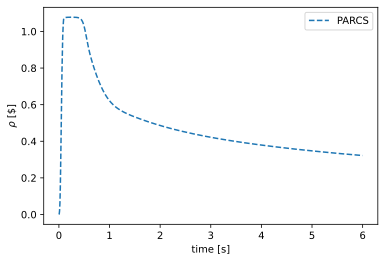

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

plt.plot(t,rho_imp/beta_sum,label='PARCS',linestyle='--')
plt.xlabel('time [s]')
plt.ylabel('$\\rho$ [\$]')
plt.legend()
plt.show()

# Write Input Data to XML File

In [3]:
import xml.etree.ElementTree as ET
from xml.dom import minidom

epke_input = ET.Element("epke_input", theta="0.5", gamma_d="0.0", 
                        initial_power="1e-6", eta="1.0")
precursors_element = ET.SubElement(epke_input, "precursors")

for p in precursors:
    ET.SubElement(precursors_element, "precursor", 
                  decay_constant=str(p.decay_constant), 
                  beta=str(p.beta))
ET.SubElement(epke_input, "time").text = ' '.join(map(str, t))
ET.SubElement(epke_input, "gen_time").text = ' '.join(map(str, gen_time))  
ET.SubElement(epke_input, "pow_norm").text = ' '.join(map(str, pow_norm))
ET.SubElement(epke_input, "rho_imp").text = ' '.join(map(str, rho_imp))
ET.SubElement(epke_input, "beta_eff").text = ' '.join(map(str, beta_eff))
ET.SubElement(epke_input, "lambda_h").text = ' '.join(map(str, lambduh_h))

# pretty print and write to xml
xmlstr = minidom.parseString(ET.tostring(epke_input)).toprettyxml(indent="   ")
with open("epke_input.xml", "w") as f:
    f.write(xmlstr)

# Run the EPKE Executable

In [4]:
import subprocess

args = "./epke-run examples/epke_input.xml".split()
popen = subprocess.Popen(args, cwd="..", stdout=subprocess.PIPE)
popen.wait()
while True:
    line = popen.stdout.readline()
    if not line:
        break
    print(line.rstrip().decode('utf-8'))

Reading input file: examples/epke_input.xml


# Read the XML Output

In [5]:
tree = ET.parse('epke_output.xml')
root = tree.getroot()

for child in root:
    if (child.tag == 'time'):
        time_out = np.fromstring(child.attrib['values'], dtype=float, sep=',')
    if (child.tag == 'power'):
        p_out = np.fromstring(child.attrib['values'], dtype=float, sep=',')

# Plot the Results

In [6]:
plt.plot(t,p_out,label='PKE solver (6 group)')
plt.plot(t,relative_power,label='PARCS',linestyle='--')
plt.xlabel('time [s]')
plt.ylabel('p(t)')
plt.legend()
plt.show()

NameError: name 'p_out' is not defined